In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

import time

from math import *

In [2]:
N_grid=34698

t_start=1913.5
t_end=2008.5
t=np.linspace(t_start, t_end, N_grid)
h=t[1]-t[0]

dw=0.1
p=365*11+2

W=2*np.pi/11
T=11

st=int(p/2)+1
fn=N_grid-st-1

In [3]:
s=44
T_sin=s*365
m=1.5
eps=np.pi/2-0.1

weight=0.5

k0_s=weight*(np.sin((2*np.pi)/s*t+eps)+m)

In [4]:
alpha=0.999
wait_time=int(1/(1-alpha))*3
sigma=0.001
t_t=np.linspace(t_start-wait_time/365, t_end, N_grid+wait_time)
k0_clear=weight*(np.sin((2*np.pi)/s*t_t+eps)+m)

In [5]:
samples=150
res=np.zeros((fn-st+1, samples))

In [6]:
for jj in range(samples): 
    start=time.time()
    k0_t=np.zeros(N_grid+wait_time, np.dtype(float))
    np.random.seed
    xi=sigma*np.random.randn(N_grid+wait_time)

    for i in range(N_grid+wait_time):
        if i==0:
            k0_t[i]=0
        else:
            k0_t[i]=alpha*k0_t[i-1]+xi[i-1]

    k0_t=k0_t+k0_clear

    k0=np.zeros(N_grid, np.dtype(float))
    k0=k0_t[3*int(1/(1-alpha)):]
    if k0[0]<2*dw:
        k0[0]=k0_clear[int(1/(1-alpha))]
        print("ЭТА ЗАРАЗА СЛОМАЛАСЬ ОПЯТЬ")

    k0_f=interpolate.interp1d(t, k0, bounds_error=False, fill_value="extrapolate")
    f=lambda t, x: 2*dw-k0_f(t)*sin(x)
    init=np.arcsin(2*dw/k0[0])
    theta=[0]*N_grid
    for i in range(N_grid):
        if i==0:
            theta[i]=init
        else:
            k1=f(t[i-1], theta[i-1])*h
            k2=f(t[i-1]+h/2, theta[i-1]+k1/2)*h
            k3=f(t[i-1]+h/2, theta[i-1]+k2/2)*h
            k4=f(t[i-1]+h, theta[i-1]+k3)*h

            theta[i]=theta[i-1]+(k1+2*k2+2*k3+k4)/6

    theta=np.array(theta)
    x0=np.sin(W*t)
    y0=np.sin(W*t+theta)
    C_0=[0]*N_grid
    for i in range(N_grid):
        if (t[i]-T/2>=t_start) and (t[i]+T/2<=t_end):
            C_0[i]=np.corrcoef(x0[i-int(p/2):i+int(p/2)], y0[i-int(p/2):i+int(p/2)])[0][1]
        else:
            C_0[i]=nan
    phi0=np.arccos(C_0)
    k_hat=np.divide(np.array([2*dw]*N_grid), np.sin(phi0))
    res[:,jj]=k_hat[st:fn+1]
    finish=time.time()
    print(jj, ' ::: ', finish-start)

np.savetxt('PT3011_k_hat_sine+ar_single_0.001_dw_0.1W3.out', res, delimiter=',')

0  :::  27.634326219558716
1  :::  25.89533567428589
2  :::  29.47134041786194
3  :::  22.563740968704224
4  :::  18.69631814956665
5  :::  18.405704021453857
6  :::  20.914777040481567
7  :::  25.809759855270386
8  :::  21.89841938018799
9  :::  21.74847936630249
10  :::  24.582653284072876
11  :::  23.319138526916504
12  :::  26.427764654159546
13  :::  22.032100200653076
14  :::  23.421844244003296
15  :::  23.04717254638672
16  :::  31.352118968963623
17  :::  28.65517520904541
18  :::  23.573524475097656
19  :::  22.04124879837036
20  :::  23.823947191238403
21  :::  23.359864711761475
22  :::  21.40598464012146
23  :::  22.31513738632202
24  :::  20.039405345916748
25  :::  19.182038068771362
26  :::  18.21100091934204
27  :::  18.683478593826294
28  :::  18.547667503356934
29  :::  17.493847608566284
30  :::  17.541941165924072
31  :::  17.8231782913208
32  :::  18.862958908081055
33  :::  17.50993251800537
34  :::  17.595272541046143
35  :::  20.825483798980713
36  :::  19.5254

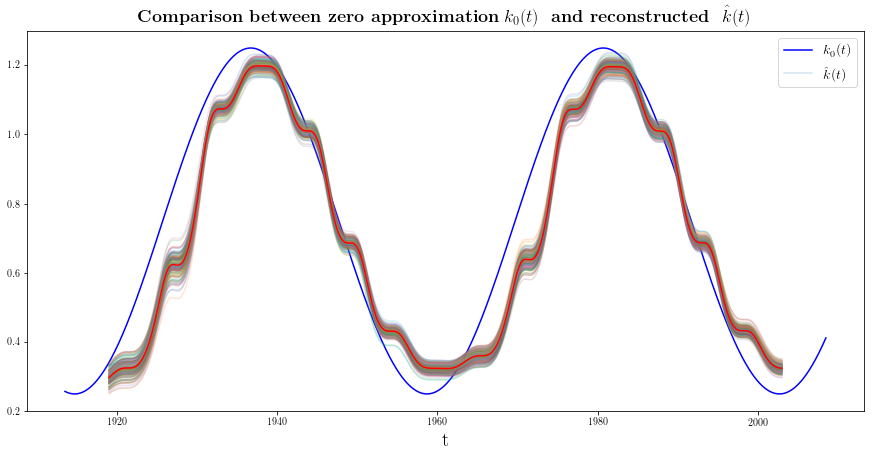

In [7]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(15, 7))
plt.plot(t, k0_s, 'b')
for i in range(samples):
    plt.plot(t[st:fn+1], res[:, i], alpha=0.2)
plt.plot(t[st:fn+1], np.mean(res, axis=1), 'r')
#plt.plot(t, k_hat, 'r')
plt.legend([r'$k_0(t)$', r'$\hat{k}(t)$'], fontsize=14)
plt.xlabel(r't', fontsize=20)
plt.title(r'\textbf{Comparison between zero approximation} $k_0(t)$ \textbf{ and reconstructed } $\hat{k}(t)$', fontsize=18)
plt.show()


In [8]:
k_hat_l=np.zeros(fn-st+1)
k_hat_u=np.zeros(fn-st+1)

for i in range(fn+1-st):
    k_hat_l[i]=sorted(res[i,:])[4]
    k_hat_u[i]=sorted(res[i,:])[145]

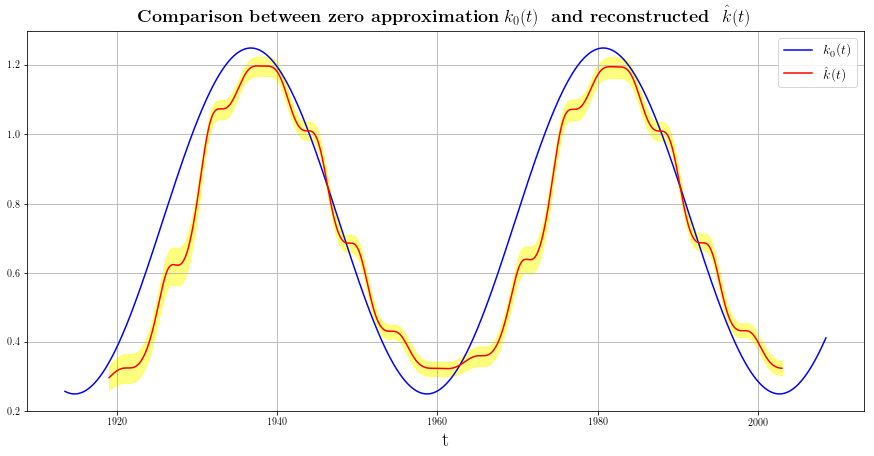

In [9]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(15, 7))
plt.plot(t, k0_s, 'b')
plt.plot(t[st:fn+1], np.mean(res, axis=1), 'r')
plt.fill_between(t[st:fn+1], k_hat_l, k_hat_u, color="yellow", alpha=0.5)
#plt.plot(t[st:fn+1], k_hat_u-k_hat_l, 'm.-', linewidth=2)
#plt.plot(t[st:fn+1], np.divide(k_hat_u-k_hat_l, np.mean(res, axis=1)-2*dw), 'g.-', linewidth=2)
#plt.plot(t, k_hat, 'r')
plt.legend([r'$k_0(t)$', r'$\hat{k}(t)$'], fontsize=14)
plt.xlabel(r't', fontsize=20)
plt.title(r'\textbf{Comparison between zero approximation} $k_0(t)$ \textbf{ and reconstructed } $\hat{k}(t)$', fontsize=18)
plt.grid()
plt.show()


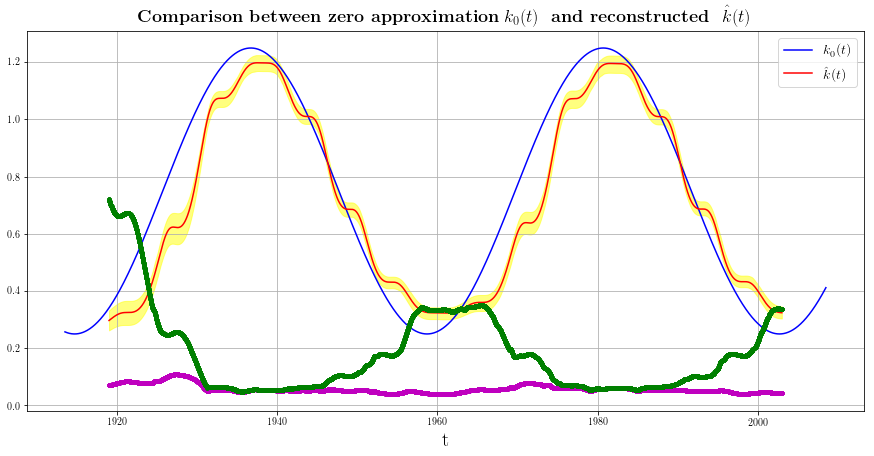

In [10]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(15, 7))
plt.plot(t, k0_s, 'b')
plt.plot(t[st:fn+1], np.mean(res, axis=1), 'r')
plt.fill_between(t[st:fn+1], k_hat_l, k_hat_u, color="yellow", alpha=0.5)
plt.plot(t[st:fn+1], (k_hat_u-k_hat_l), 'm.-', linewidth=2)
plt.plot(t[st:fn+1], np.divide(k_hat_u-k_hat_l, np.mean(res, axis=1)-2*dw), 'g.-', linewidth=2)
#plt.plot(t, k_hat, 'r')
plt.legend([r'$k_0(t)$', r'$\hat{k}(t)$'], fontsize=14)
plt.xlabel(r't', fontsize=20)
plt.title(r'\textbf{Comparison between zero approximation} $k_0(t)$ \textbf{ and reconstructed } $\hat{k}(t)$', fontsize=18)
plt.grid()
plt.show()
